### Import the required libraries:

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sympy import false

In [2]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Load the training_data file

In [3]:
df=pd.read_csv("training_data_lowercase.csv", sep='\t', names=["labels", "text"], header=None)
print(df.columns)
print(df.head())

Index(['labels', 'text'], dtype='object')
   labels                                               text
0       0  donald trump sends out embarrassing new year‚s...
1       0  drunk bragging trump staffer started russian c...
2       0  sheriff david clarke becomes an internet joke ...
3       0  trump is so obsessed he even has obama‚s name ...
4       0  pope francis just called out donald trump duri...


In [4]:

data_train=df["text"]
data_test=df["labels"]

### Clean data

Only Lowercase and Tokenization ( without Stop words / Lemmatization)

In [5]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
punctuation_table = str.maketrans('', '', string.punctuation)

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # lowercase
    #text = text.translate(punctuation_table)  # remove punctuation
    tokens = word_tokenize(text)  # tokenize
    #clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    #return ' '.join(clean_tokens)
    return ' '.join(tokens)

filter_data = data_train.apply(preprocess_text)


### Split the data for train and test

In [6]:
from sklearn.model_selection import train_test_split

X=filter_data
y=data_test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape)
print(X_test.shape)

(27321,)
(6831,)


### Load the vectorizer and vectorize the data

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

# Word-level TF-IDF
tfidf_word = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # unigrams + bigrams

# Char-level TF-IDF
tfidf_char = TfidfVectorizer(max_features=5000, analyzer='char', ngram_range=(3,5))

# Combine features
vectorizer = FeatureUnion([
    ('word', tfidf_word),
    ('char', tfidf_char)
])

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_test)

In [8]:
print(X_val_tfidf.shape)
print(X_train_tfidf.shape)

(6831, 15000)
(27321, 15000)


**Initialize the model and train the model**

In [9]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": LinearSVC(max_iter=1000),
    "XGBoost": XGBClassifier(
        n_estimators=300,      # number of trees
        max_depth=6,           # max depth of each tree
        learning_rate=0.1,
        # use_label_encoder=False,
        # eval_metric='logloss', # suppress warning
        # random_state=42
    )
}

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

results = []

for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_val_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Store results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

# Compare all results in a table
results_df = pd.DataFrame(results)
print(results_df)

# Model                 Accuracy Precision Recall   F1-score
# 0 Logistic Regression 0.943786 0.929623  0.956087 0.942669
# 1 Multinomial NB      0.929293 0.925960  0.927922 0.926940
# 2 Random Forest       0.921681 0.895625  0.948516 0.921312
# 3 Linear SVM          0.952862 0.947716  0.955179 0.951433

#                  Model  Accuracy  Precision    Recall  F1-score
# 0  Logistic Regression  0.943786   0.929623  0.956087  0.942669
# 1       Multinomial NB  0.929293   0.925960  0.927922  0.926940
# 2        Random Forest  0.921681   0.895625  0.948516  0.921312
# 3           Linear SVM  0.952862   0.947716  0.955179  0.951433
# 4              XGBoost  0.921095   0.886218  0.960024  0.921646

Training Logistic Regression...
Training Multinomial NB...
Training Random Forest...
Training Linear SVM...
Training XGBoost...
                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.959889   0.949792  0.968201  0.958908
1       Multinomial NB  0.945250   0.937015  0.950636  0.943776
2        Random Forest  0.952130   0.935069  0.968201  0.951347
3           Linear SVM  0.967647   0.962752  0.970624  0.966672
4              XGBoost  0.962963   0.948778  0.976075  0.962233


### Previous experiment results:

| Model                | Accuracy  | Precision | Recall   | F1-score |
|----------------------|----------|-----------|---------|----------|
| Logistic Regression  | 0.943786 | 0.929623  | 0.956087 | 0.942669 |
| Multinomial NB       | 0.929293 | 0.925960  | 0.927922 | 0.926940 |
| Random Forest        | 0.921681 | 0.895625  | 0.948516 | 0.921312 |
| Linear SVM           | 0.952862 | 0.947716  | 0.955179 | 0.951433 |



| Model                | Accuracy  | Precision | Recall   | F1-score |
|----------------------|----------|-----------|---------|----------|
| Logistic Regression  | 0.943786 | 0.929623  | 0.956087 | 0.942669 |
| Multinomial NB       | 0.929293 | 0.925960  | 0.927922 | 0.926940 |
| Random Forest        | 0.921681 | 0.895625  | 0.948516 | 0.921312 |
| Linear SVM           | 0.952862 | 0.947716  | 0.955179 | 0.951433 |
| XGBoost              | 0.921095 | 0.886218  | 0.960024 | 0.921646 |


### Plotting the results

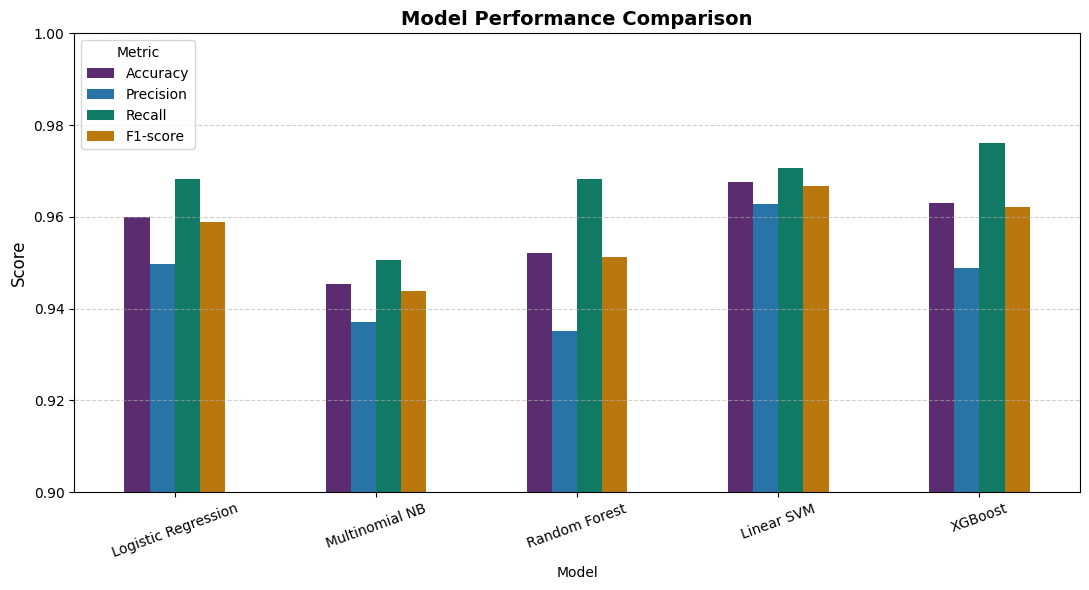

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Multinomial NB", "Random Forest", "Linear SVM", "XGBoost"],
    "Accuracy": [0.959889, 0.945250, 0.952130, 0.967647, 0.962963],
    "Precision": [0.949792, 0.937015, 0.935069, 0.962752, 0.948778],
    "Recall": [0.968201, 0.950636, 0.968201, 0.970624, 0.976075],
    "F1-score": [0.958908, 0.943776, 0.951347, 0.966672, 0.962233]
})

df = pd.DataFrame(data)

colors = ["#5B2C6F", "#2874A6", "#117A65", "#B9770E", "#922B21"]

# Plot
ax = df.set_index("Model").plot(
    kind="bar",
    figsize=(11,6),
    rot=20,
    color=colors
)
ax.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
ax.set_ylabel("Score", fontsize=12)
ax.set_ylim(0.90, 1.00)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(title="Metric")
plt.tight_layout()
plt.show()


**Create prediction with validation data**

In [15]:
y_pred = model.predict(X_val_tfidf)

**Calculate accuracy score based on prediction**

In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9629629629629629


**Confusion matrix based on test and prediction**

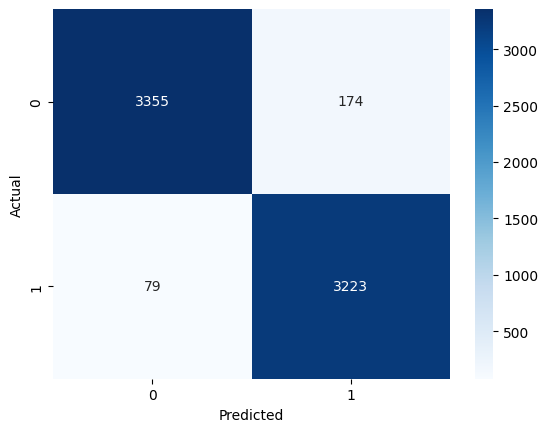

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Test the model with load the test data**

In [18]:
test_data=pd.read_csv("testing_data_lowercase_nolabels.csv", sep='\t', names=["labels", "text"], header=None)

**Prepocess the test data**

In [24]:
test_data.columns

Index(['labels', 'text'], dtype='object')

### Training the XGBoost Model on Preprocessed TF-IDF Features



In [27]:
from xgboost import XGBClassifier

# Preprocess training text
train_df = pd.read_csv("training_data_lowercase.csv", sep='\t', names=["labels","text"], header=None)
train_text = train_df['text'].astype(str).apply(preprocess_text)
train_labels = train_df['labels'].astype(int)

# Fit TF-IDF vectorizer (same as before)
X_train_tfidf = vectorizer.fit_transform(train_text)

# Train final model
final_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
final_model.fit(X_train_tfidf, train_labels)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:35:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

### Predicting Labels on Test Data Using Preprocessed TF-IDF and XGBoost

In [28]:
import pandas as pd

# --- 1️⃣ Load test data ---
test_df = pd.read_csv("testing_data_lowercase_nolabels.csv", sep='\t', names=["labels","text"], header=None)

# Ensure 'text' column is string
test_df['text'] = test_df['text'].astype(str)

# --- 2️⃣ Apply the same preprocessing as training ---
test_text = test_df['text'].apply(preprocess_text)

# --- 3️⃣ Transform using the already fitted TF-IDF vectorizer ---
X_test_tfidf = vectorizer.transform(test_text)  # DO NOT fit again

# --- 4️⃣ Predict using the trained XGBoost model ---
y_test_pred = final_model.predict(X_test_tfidf)

# --- 5️⃣ Save predictions to CSV ---
test_df['labels'] = y_test_pred
test_df.to_csv("predicted_test_data.csv", index=False, header=False)

print("Predictions saved to 'predicted_test_data.csv'.")


Predictions saved to 'predicted_test_data.csv'.


### Check predictions

In [29]:
# Show first 10 predictions
print(test_df.head(10))

# Check prediction counts for each class
print(test_df['labels'].value_counts())


   labels                                               text
0       0  copycat muslim terrorist arrested with assault...
1       0  wow! chicago protester caught on camera admits...
2       1   germany's fdp look to fill schaeuble's big shoes
3       0  mi school sends welcome back packet warning ki...
4       1  u.n. seeks 'massive' aid boost amid rohingya '...
5       0  did oprah just leave ‚nasty‚ hillary wishing s...
6       1  france's macron says his job not 'cool' cites ...
7       0  flashback: chilling ‚60 minutes‚ interview wit...
8       1  spanish foreign ministry says to expel north k...
9       1  trump says cuba 'did some bad things' aimed at...
labels
1    5147
0    4837
Name: count, dtype: int64
